In [1]:
import json
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import torch
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.feature_extraction import DictVectorizer
import matplotlib.pyplot as plt
torch.manual_seed(4)

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip

--2021-12-13 04:45:53--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  6.95MB/s    in 0.8s    

2021-12-13 04:45:54 (6.95 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


In [4]:
ratings_full = pd.read_csv('./ml-1m/ratings.dat', sep = '::', header = None, encoding = 'latin-1', names=['user_id', 'movie_id', 'rating', 'timestamp'])
#imdb_data = pd.read_json('movieLens_1M_dump.txt')
#imdb_data = imdb_data.T
#imdb_data.reset_index(inplace=True)
#imdb_data = imdb_data.rename(columns = {'index':'movie_id'})
users = pd.read_csv('./ml-1m/users.dat', sep = '::', header = None, encoding = 'latin-1', names=['user_id', 'gender', 'age', 'occupation', 'zip_code'])
users.gender[users.gender == 'M'] = 1
users.gender[users.gender == 'F'] = 0
movies = pd.read_csv('./ml-1m/movies.dat', sep = '::', header = None, encoding = 'latin-1', names=['movie_id', 'movie', 'genre'])
ratings = ratings_full.merge(users, how='inner', on='user_id')
ratings = ratings.merge(movies, how='inner', on='movie_id')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-pac

In [5]:
user_genre_mapping = ratings.groupby(['user_id'])['genre'].apply(lambda x: '|'.join(x))
def get_genre_counts(genres):
  counts = Counter()
  for genre in genres.split('|'):
    counts[genre] += 1
  return counts
vectorizer = DictVectorizer()
X = vectorizer.fit_transform(user_genre_mapping.apply(lambda x: get_genre_counts(x)).values)

In [6]:
user_genre_vector = pd.DataFrame({user:genre_vector for user, genre_vector in zip(user_genre_mapping.index, X.toarray())}).T
user_genre_vector.columns = vectorizer.get_feature_names_out()
user_genre_vector = user_genre_vector.rename_axis('user_id').reset_index()

In [7]:
ratings = ratings.merge(user_genre_vector, how='inner', on='user_id')

In [8]:
'Mapping userid and movieid to a consistent data space'
user_mapping = {user:index for index, user in enumerate(ratings['user_id'].unique())}
movie_mapping = {movie:index for index, movie in enumerate(ratings['movie_id'].unique())}

In [9]:
ratings['user_id_mapped'] = [user_mapping[user_id] for user_id in ratings['user_id']]
ratings['movie_id_mapped'] = [movie_mapping[movie_id] for movie_id in ratings['movie_id']]

In [10]:
ratings.head()

,user_id,movie_id,rating,timestamp,gender,age,occupation,zip_code,movie,genre,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,user_id_mapped,movie_id_mapped
0,1,1193,5,978300760,0,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama,5.0,5.0,18.0,20.0,14.0,2.0,0.0,21.0,3.0,0.0,0.0,14.0,0.0,6.0,3.0,3.0,2.0,0.0,0,0
1,1,661,3,978302109,0,1,10,48067,James and the Giant Peach (1996),Animation|Children's|Musical,5.0,5.0,18.0,20.0,14.0,2.0,0.0,21.0,3.0,0.0,0.0,14.0,0.0,6.0,3.0,3.0,2.0,0.0,0,1
2,1,914,3,978301968,0,1,10,48067,My Fair Lady (1964),Musical|Romance,5.0,5.0,18.0,20.0,14.0,2.0,0.0,21.0,3.0,0.0,0.0,14.0,0.0,6.0,3.0,3.0,2.0,0.0,0,2
3,1,3408,4,978300275,0,1,10,48067,Erin Brockovich (2000),Drama,5.0,5.0,18.0,20.0,14.0,2.0,0.0,21.0,3.0,0.0,0.0,14.0,0.0,6.0,3.0,3.0,2.0,0.0,0,3
4,1,2355,5,978824291,0,1,10,48067,"Bug's Life, A (1998)",Animation|Children's|Comedy,5.0,5.0,18.0,20.0,14.0,2.0,0.0,21.0,3.0,0.0,0.0,14.0,0.0,6.0,3.0,3.0,2.0,0.0,0,4


In [11]:
ratings.sort_values(by='timestamp', ascending=True, inplace=True)

In [12]:
training_set, test_set = train_test_split(ratings, test_size=0.2, shuffle=False)
training_set, validation_set = train_test_split(training_set, test_size=0.2, shuffle=False)
print(training_set.shape)
print(validation_set.shape)
print(test_set.shape)

(640133, 30)
(160034, 30)
(200042, 30)


In [13]:
n_users = len(ratings['user_id_mapped'].unique())
n_movies = len(ratings['movie_id_mapped'].unique())

In [14]:
print('Num of users: ', n_users, '\nNum of movies: ', n_movies)

Num of users:  6040 
Num of movies:  3706


In [15]:
def convert(data, num_movies, add_features):
    
    for user_id in data['user_id_mapped'].unique():
      filter_user = data['user_id_mapped'] == user_id
      movie_ids = data.loc[:, 'movie_id_mapped'][filter_user]
      user_ratings = data.loc[:, 'rating'][filter_user]
      features = np.zeros(num_movies)
      features[movie_ids] = user_ratings
      for feauture in add_features:
        feature_value = data.loc[:, feauture][filter_user].iloc[0]
        features = np.append(features, feature_value)
      yield features
    

In [40]:
'''

Defining our Dataset for batch processing
'''

from torch.utils.data import DataLoader, IterableDataset
class Dataset(IterableDataset):

  def __init__(self, path):
    self._path = path

  def __iter__(self):
    for line in open(self._path):
      input = np.array(json.loads(line))
      yield {'input':input, 'target':input}


def generate_batches(dataset, batch_size, shuffle=False, drop_last=True, device='cpu'):
  data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)
  for data_dict in data_loader:
    out_data_dict = {}
    for name, tensor in data_dict.items():
      out_data_dict[name] = data_dict[name].to(device)
    yield out_data_dict



In [41]:
''' 
Creating NN
'''

class Model(nn.Module):
    def __init__(self, num_features):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(num_features, 300)
        self.fc2 = nn.Linear(300, 100)
        self.fc22 = nn.Linear(100, 50)
        self.fc23 = nn.Linear(50, 20)
        self.fc24 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 20)
        self.fc31 = nn.Linear(20, 50)
        self.fc32 = nn.Linear(50, 100)
        self.fc33 = nn.Linear(100, 300)
        self.fc4 = nn.Linear(300, num_features)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc22(x))
        x = self.activation(self.fc23(x))
        x = self.activation(self.fc24(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc31(x))
        x = self.activation(self.fc32(x))
        x = self.activation(self.fc33(x))
        x = self.fc4(x)
        return x

In [42]:
''' 
Train model
'''
def trainModel(train_dataset, validation_dataset):
  trainErrorVal=dict()
  validationErrorVal=dict()
  
  for epoch in range(num_epochs):
    batch_generator = generate_batches(train_dataset, batch_size=batch_size, device=device)
    model.train()
    running_loss = 0.0
    for batch_index, batch_dict in enumerate(batch_generator):
      optimizer.zero_grad()
      output = model(batch_dict['input'].float())
      output[batch_dict['target'] == 0] = 0
      loss = criterion(output[:, :n_movies], batch_dict['target'].float()[:, :n_movies])
      mse_loss = torch.divide(loss, torch.sum(batch_dict['target'] > 0).float())
      running_loss += (mse_loss.item() - running_loss) / (batch_index + 1)
      mse_loss.backward()
      optimizer.step()

      
    print('epoch: '+str(epoch) + ' Train loss: ' + str(running_loss))
    if epoch%2==0:
      trainErrorVal[epoch]=running_loss


    batch_generator = generate_batches(validation_dataset, batch_size=batch_size, device=device, drop_last=False)
    model.eval()
    running_loss = 0.0
    for batch_index, batch_dict in enumerate(batch_generator):
      output = model(batch_dict['input'].float())
      output[batch_dict['target'] == 0] = 0
      loss = criterion(output[:, :n_movies], batch_dict['target'].float()[:, :n_movies])
      mse_loss = torch.divide(loss, torch.sum(batch_dict['target'] > 0).float())
      running_loss += (mse_loss.item() - running_loss) / (batch_index + 1)
    scheduler.step(running_loss)

    print('epoch: '+str(epoch) + ' Validation loss: ' + str(running_loss))
    if epoch%2==0:
      validationErrorVal[epoch]=running_loss
  
  plt.plot(list(trainErrorVal.keys()), list(trainErrorVal.values()), 'g', label='Training loss')
  plt.plot(list(validationErrorVal.keys()), list(validationErrorVal.values()), 'b', label='validation loss')
  plt.autoscale(enable=True, axis='y')

  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  

In [43]:
'''
Test Model

'''
def TestModel(test_dataset):
  criterion = nn.L1Loss(reduction='sum')
  batch_generator = generate_batches(test_dataset, batch_size=batch_size, device=device, drop_last=False)
  model.eval()
  running_loss = 0.0
  for batch_index, batch_dict in enumerate(batch_generator):
    output = model(batch_dict['input'].float())
    output[batch_dict['target'] == 0] = 0
    loss = criterion(output[:, :n_movies], batch_dict['target'].float()[:, :n_movies])
    mse_loss = torch.divide(loss, torch.sum(batch_dict['target'] > 0).float())
    running_loss += (mse_loss.item() - running_loss) / (batch_index + 1)
  print('Test loss: ' + str(running_loss))




In [47]:
''' 
Run Model with just user and ratings
'''
number_of_features = n_movies
with open('./training.jsonl', 'w') as file:
  for data in  convert(training_set, n_movies, []):
    file.write(json.dumps(list(data)) + '\n')
with open('./validation.jsonl', 'w') as file:
  for data in  convert(validation_set, n_movies, []):
    file.write(json.dumps(list(data)) + '\n')
with open('./test.jsonl', 'w') as file:
  for data in  convert(test_set, n_movies, []):
    file.write(json.dumps(list(data)) + '\n')

In [48]:
''' 
Run Model with just user and ratings and user attribubtes
'''
add_features = ['gender', 'age', 'occupation']
number_of_features_user = n_movies + len(add_features)
with open('./training_user.jsonl', 'w') as file:
  for data in  convert(training_set, n_movies, add_features):
    file.write(json.dumps(list(data)) + '\n')
with open('./validation_user.jsonl', 'w') as file:
  for data in  convert(validation_set, n_movies, add_features):
    file.write(json.dumps(list(data)) + '\n')
with open('./test_user.jsonl', 'w') as file:
  for data in  convert(test_set, n_movies, add_features):
    file.write(json.dumps(list(data)) + '\n')

In [49]:
''' 
Run Model with just user and ratings and genres
'''
add_features_genre = ['gender', 'age', 'occupation'] + list(vectorizer.get_feature_names_out())
number_of_features_genre = n_movies + len(add_features_genre)
with open('./training_user_genres.jsonl', 'w') as file:
  for data in  convert(training_set, n_movies, add_features_genre):
    file.write(json.dumps(list(data)) + '\n')
with open('./validation_user_genres.jsonl', 'w') as file:
  for data in  convert(validation_set, n_movies, add_features_genre):
    file.write(json.dumps(list(data)) + '\n')
with open('./test_user_genres.jsonl', 'w') as file:
  for data in  convert(test_set, n_movies, add_features_genre):
    file.write(json.dumps(list(data)) + '\n')

In [50]:
train_dataset = Dataset('./training.jsonl')
validation_dataset = Dataset('./validation.jsonl')
test_dataset = Dataset('./test.jsonl')
number_of_features = n_movies

In [51]:
train_user_dataset = Dataset('./training_user.jsonl')
validation_user_dataset = Dataset('./validation_user.jsonl')
test_user_dataset = Dataset('./test_user.jsonl')
number_of_features_user = n_movies + len(add_features)

In [52]:
train_user_genre_dataset = Dataset('./training_user_genres.jsonl')
validation_user_genre_dataset = Dataset('./validation_user_genres.jsonl')
test_user_genre_dataset = Dataset('./test_user_genres.jsonl')
number_of_features_user_genre = n_movies + len(add_features_genre)

In [53]:
num_epochs = 75
batch_size = 2048

In [54]:
''' 
Defining model parameters

'''
model = Model(number_of_features)
model.to(device)
#Create loss object
criterion = nn.L1Loss(reduction='sum')
#criterion = nn.MSELoss()

#create optimizer object
#parameters of all auto-encoders defined in the class
optimizer = optim.Adam(model.parameters(), 0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)

epoch: 0 Train loss: 3.41107439994812
epoch: 0 Validation loss: 10.887405395507812
epoch: 1 Train loss: 7.70603084564209
epoch: 1 Validation loss: 3.336851119995117
epoch: 2 Train loss: 3.44175124168396
epoch: 2 Validation loss: 3.3863797187805176
epoch: 3 Train loss: 3.4479061365127563
epoch: 3 Validation loss: 3.2498230934143066
epoch: 4 Train loss: 3.223252296447754
epoch: 4 Validation loss: 2.578293561935425
epoch: 5 Train loss: 2.2409263849258423
epoch: 5 Validation loss: 3.139085054397583
epoch: 6 Train loss: 2.557756781578064
epoch: 6 Validation loss: 1.936941385269165
epoch: 7 Train loss: 2.0647969841957092
epoch: 7 Validation loss: 2.124861240386963
epoch: 8 Train loss: 2.025098979473114
epoch: 8 Validation loss: 1.4446178674697876
epoch: 9 Train loss: 1.3955734372138977
epoch: 9 Validation loss: 1.565091848373413
epoch: 10 Train loss: 1.3713080883026123
epoch: 10 Validation loss: 1.0964809656143188
epoch: 11 Train loss: 1.0892756581306458
epoch: 11 Validation loss: 1.04159164

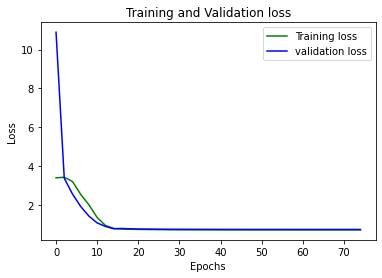

In [55]:
trainModel(train_dataset, validation_dataset)

In [56]:
TestModel(test_dataset)

Test loss: 0.7396325469017029


In [57]:
''' 
Defining model parameters

'''
model = Model(number_of_features_user)
model.to(device)
#Create loss object
criterion = nn.L1Loss(reduction='sum')
#criterion = nn.MSELoss()

#create optimizer object
#parameters of all auto-encoders defined in the class
optimizer = optim.Adam(model.parameters(), 0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)

In [58]:
num_epochs = 75
batch_size = 2048

epoch: 0 Train loss: 3.475197434425354
epoch: 0 Validation loss: 2.0911684036254883
epoch: 1 Train loss: 2.6021478176116943
epoch: 1 Validation loss: 2.787436008453369
epoch: 2 Train loss: 2.5703306198120117
epoch: 2 Validation loss: 1.749685525894165
epoch: 3 Train loss: 1.5436058044433594
epoch: 3 Validation loss: 1.1781388521194458
epoch: 4 Train loss: 1.0641960203647614
epoch: 4 Validation loss: 0.8914732933044434
epoch: 5 Train loss: 0.8162816166877747
epoch: 5 Validation loss: 0.812520444393158
epoch: 6 Train loss: 0.8115913271903992
epoch: 6 Validation loss: 0.840789794921875
epoch: 7 Train loss: 0.8139676451683044
epoch: 7 Validation loss: 0.8115130662918091
epoch: 8 Train loss: 0.7890333533287048
epoch: 8 Validation loss: 0.801377534866333
epoch: 9 Train loss: 0.7786724865436554
epoch: 9 Validation loss: 0.7930619120597839
epoch: 10 Train loss: 0.7758815288543701
epoch: 10 Validation loss: 0.7912553548812866
epoch: 11 Train loss: 0.7718517184257507
epoch: 11 Validation loss: 0

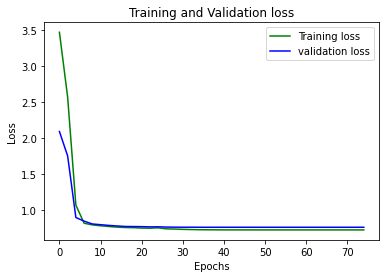

In [59]:
trainModel(train_user_dataset, validation_user_dataset)

In [60]:
TestModel(test_user_dataset)

Test loss: 0.7355971336364746


In [61]:
''' 
Defining model parameters

'''
model = Model(number_of_features_user_genre)
model.to(device)
#Create loss object
criterion = nn.L1Loss(reduction='sum')
#criterion = nn.MSELoss()

#create optimizer object
#parameters of all auto-encoders defined in the class
optimizer = optim.Adam(model.parameters(), 0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)

epoch: 0 Train loss: 3.1188849210739136
epoch: 0 Validation loss: 2.3990583419799805
epoch: 1 Train loss: 2.5478153228759766
epoch: 1 Validation loss: 2.5172574520111084
epoch: 2 Train loss: 2.515008330345154
epoch: 2 Validation loss: 1.49568772315979
epoch: 3 Train loss: 2.624911904335022
epoch: 3 Validation loss: 1.3034496307373047
epoch: 4 Train loss: 1.5277161002159119
epoch: 4 Validation loss: 1.8232421875
epoch: 5 Train loss: 1.9112024903297424
epoch: 5 Validation loss: 1.602855920791626
epoch: 6 Train loss: 1.612456202507019
epoch: 6 Validation loss: 1.2367005348205566
epoch: 7 Train loss: 1.162724494934082
epoch: 7 Validation loss: 0.8618783354759216
epoch: 8 Train loss: 0.9075939357280731
epoch: 8 Validation loss: 1.0723847150802612
epoch: 9 Train loss: 1.0226725041866302
epoch: 9 Validation loss: 0.8189266324043274
epoch: 10 Train loss: 0.7680575549602509
epoch: 10 Validation loss: 0.7029475569725037
epoch: 11 Train loss: 0.717013955116272
epoch: 11 Validation loss: 0.7300897

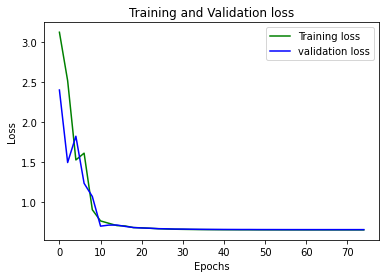

In [62]:
trainModel(train_user_genre_dataset, validation_user_genre_dataset)

In [63]:
TestModel(test_user_genre_dataset)

Test loss: 0.6327607035636902
